In [2]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 408 (delta 267), reused 228 (delta 164), pack-reused 74 (from 1)
Receiving objects: 100% (408/408), 1.83 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [7]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 8bc2290..8cf06eb
Fast-forward
 fed_lib/fed_methods.py |  1122 +---
 fed_lib/fed_model.py   |     4 +-
 fed_lib/utils.py       |    27 +-
 fedprox.ipynb          |   294 +
 fedsam.ipynb           | 15983 +----------------------------------------------
 task1.ipynb            |     2 +-
 task2.ipynb            |  2928 +++------
 7 files changed, 1497 insertions(+), 18863 deletions(-)


In [2]:
%cd test

/kaggle/working/test


In [3]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedProx

In [4]:
import torch
import torch.nn as nn

In [5]:
# !pip install fedlab

In [6]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [7]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

09:09:42 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedProx vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedProx (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
def fed_prox_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0, mu=0.01, train_central=False):
        
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]

        fed_meth = fed_methods.FedProx(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac, mu=mu)

        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=train_central)

        return fed

In [13]:
# f = fed_prox_exp(num_steps=5, global_runs=5, mu=0.01, train_central=True)
# plot_fed_test_acc(f.federated_method.round_metrics, f"FedProx (k={5} local rounds) Test Accuracy")
# plot_client_drift(f.federated_method.round_metrics, f"Client Drift (k={5} local rounds)")

In [14]:
def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)


    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k} Steps')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [15]:
trainset, testset = utils.get_cifar10()

In [ ]:
from IPython.display import clear_output

metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for mu in [1e-4, 0.01, 1, 5, 10]: 
    f = fed_prox_exp(lr=1e-2, num_clients=5,num_steps=100, global_runs=15, sampling_frac=0.8, mu=mu)
    metrics_exp_1[mu] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 3.881402e-01
Client Drift Std: 1.530491e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.658082e-01
Client Number: 4 Drift :3.811683e-01
Client Number: 1 Drift :3.829153e-01
Client Number: 0 Drift :4.049275e-01
Client Number: 2 Drift :4.058819e-01

Evaluate on round 1:


FedProx  | Test Loss: 2.0179, Test Acc: 23.87%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs


TypeError: list indices must be integers or slices, not str

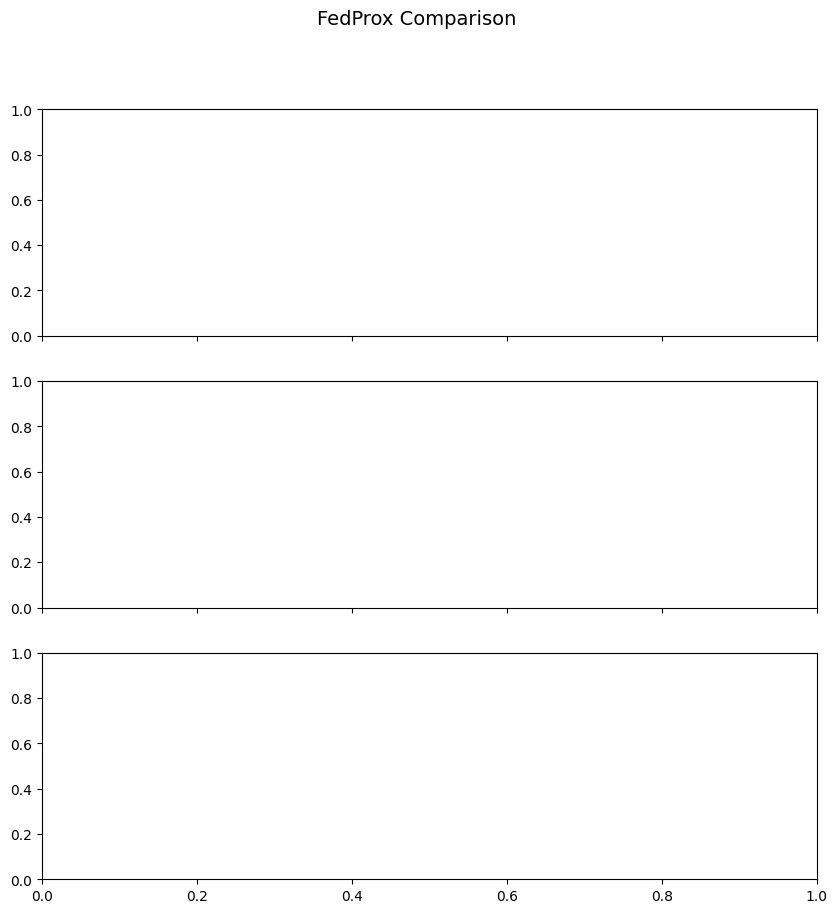

In [ ]:
plot_metrics(metrics_exp_1)